## **Import important Libraries**

In [48]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

#### Import tensorboard

In [49]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("runs/mnist2")

In Project
- MNIST
- DataLoader, Transformation
- Multilayer Neural Network, Activation Function
- Loss and Optimizer
- Training Loop (batch training)
- Model Evaluation
- GPU Support

#### Device Config

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Hyper Parameters

In [51]:
input_size = 784 # 28*28
hidden_size = 100
num_classes = 10 # digit number 0-9
num_epochs = 2
batch_size = 100
learning_rate = 0.01

#### Import MNIST dataset

torch.Size([100, 1, 28, 28]) torch.Size([100])


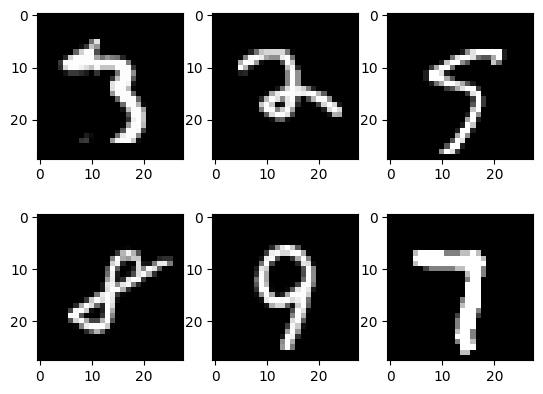

In [52]:
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False)

examples = iter(train_loader)
samples, labels = next(examples)
print(samples.shape, labels.shape)

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(samples[i][0], cmap='gray')
# plt.show()
img_grid = torchvision.utils.make_grid(samples)
writer.add_image('mnist_images', img_grid)

#### Neural Network

In [53]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # don't apply softmax function because use cross entropy
        return out

model = NeuralNet(input_size, hidden_size, num_classes)

#### Loss and Optimizer

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### Model Graph

In [55]:
writer.add_graph(model, samples.reshape(-1, 28*28))

#### Training Loop

In [56]:
n_total_steps = len(train_loader)

running_loss = 0.0
running_correct = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # 100, 1, 28, 28
        # 784 = 28*28 -- input_size
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # Forward Pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        running_correct += (predicted == labels).sum().item()

        if (i+1) % 100 == 0:
            print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')
            writer.add_scalar('Training loss', running_loss/100, epoch* n_total_steps + i)
            writer.add_scalar('Accuracy', running_correct/100, epoch* n_total_steps + i)
            running_loss = 0.0
            running_correct = 0

# test
preds = []
lbs = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)

        # value, index
        _, predictions = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct = (predictions == labels).sum().item()

        class_predictions = [F.softmax(out, dim=0) for out in outputs]

        preds.append(class_predictions)
        lbs.append(predicted)

    preds = torch.cat([torch.stack(batch) for batch in preds])
    lbs = torch.cat(lbs)
        
    acc = 100.0 * n_correct / n_samples
    print(f'accuracy = {acc}')

    classes = range(10)
    for i in classes:
        lbs_i = lbs == i
        preds_i = preds[:, i]
        writer.add_pr_curve(str(i), lbs_i, preds_i, global_step=0)

epoch 1/2, step 100/600, loss = 0.1839
epoch 1/2, step 200/600, loss = 0.2393
epoch 1/2, step 300/600, loss = 0.1188
epoch 1/2, step 400/600, loss = 0.1676
epoch 1/2, step 500/600, loss = 0.1919
epoch 1/2, step 600/600, loss = 0.1121
epoch 2/2, step 100/600, loss = 0.1010
epoch 2/2, step 200/600, loss = 0.1282
epoch 2/2, step 300/600, loss = 0.1647
epoch 2/2, step 400/600, loss = 0.0647
epoch 2/2, step 500/600, loss = 0.4060
epoch 2/2, step 600/600, loss = 0.1755
accuracy = 0.97
